In [1]:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


분류 실습 - 캐글 산탄데르 고객 만족 예측

- 클래스 레이블 명은 TARGET이며, 값이 1이면 불만을 가진 고객, 0이면 만족한 고객
- 대부분이 만족이고, 불만족인 데이터는 일부일 것이기 때문에 정확도 수치보다는 **ROU-AUC가 모델 성능 평가에 더 적합함**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df = pd.read_csv("/content/train_santander.csv", encoding = 'latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
0                      0.0                      0.0  ...   
1                      0.0                      0.0  ...   
2                      0.0                      0.0  ...   

   saldo_medio_var33_hace2  saldo_medio_var33_hace3  saldo_medio_var33_ult1  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                      0.0                      0.0                     0.0   

   saldo_medio_var33_ult3  saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   

   saldo_medio_var44_ult1  saldo_medio_var44_ult3     var38  TARGET  
0                     0.0                     0.0  39205.17       0  
1                     0.0                     0.0  49278.03       0  
2                     0.0                     0.0  67333.77       0  

[3 rows x 371 columns]

In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


클래스 값 컬럼을 포함한 피처가 371개 존재하며, 111개의 피처가 float형, 260개의 피처가 int 형으로 모든 피처가 숫자형이고 NULL 값은 없음.

In [4]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [5]:
cust_df.describe()

ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.000000       2.000000     28.000000            0.000000   
75%    113748.750000       2.000000     40.000000            0.000000   
max    151838.000000     238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529632   
std                 339.315831               546.266294   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             21024.810000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             76020.000000             76020.000000   
mean                  3.559130                 6.472698   
std                  93.155749               153.737066   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                8237.820000             11073.570000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
count             76020.000000             76020.000000  ...   
mean                  0.412946                 0.567352  ...   
std                  30.604864                36.513513  ...   
min                   0.000000                 0.000000  ...   
25%                   0.000000                 0.000000  ...   
50%                   0.000000                 0.000000  ...   
75%                   0.000000                 0.000000  ...   
max                6600.000000              6600.000000  ...   

       saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
count             76020.000000             76020.000000   
mean                  7.935824                 1.365146   
std                 455.887218               113.959637   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               50003.880000             20385.720000   

       saldo_medio_var33_ult1  saldo_medio_var33_ult3  \
count            76020.000000            76020.000000   
mean                12.215580                8.784074   
std                783.207399              538.439211   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max             138831.630000            91778.730000   

       saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
count             76020.000000             76020.000000   
mean                 31.505324                 1.858575   
std                2013.125393               147.786584   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max              438329.220000             24650.010000   

       saldo_medio_var44_ult1  saldo_medio_var44_ult3         var38  \
count            76020.000000            76020.000000  7.602000e+04   

var3의 min이 -999999인 것은 다른 데이터에 비해 편차가 크므로 가장 많은 값인 2로 변환하고, ID 피처는 단순 식별자이므로 드롭함

inplace = True를 통해 원본 데이터 자체를 수정

In [6]:
cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df.drop('ID', axis = 1, inplace = True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


학습 데이터와 테스트 데이터 세트 모두 TARGET의 값이 분포의 원본 데이터와 유사하게 4% 정도의 불만족 값으로 만들어짐. XGBoost의 조기 중단의 검증 데이터 세트로 사용하기 위해서 train 데이터 세트에서 검증 데이터 세트를 분리

In [22]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# XGBoost 모델 학습과 하이퍼 파라미터 튜닝

성능 평가 기준이 roc-auc이므로 XGBClassifier의 eval_metric을 auc로 설정. logloss로 해도 큰 차이는 없음

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimator는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators = 500, learning_rate = 0.05, random_state = 156,
                        eval_metric = "auc", early_stopping_rounds = 100)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose = 0)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8417


# 베이지안 최적화 기반으로 XGBoost 하이퍼 파라미터 튜닝 수행

In [23]:
from hyperopt import hp

# max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01dptj 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

# 목적 함수 생성
3 fold 교차 검증을 이용해 평균 roc-auc 값을 반환하되, -1을 곱해 주어 최대 roc-auc 값이 최소 반환값이 되게 함.

In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1 * roc_auc 평균 값을 반환.
def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators = 100, max_depth=int(search_space['max_depth']),
                          min_child_weight = int(search_space['min_child_weight']),
                          colsample_bytree = search_space['colsample_bytree'],
                          learning_rate = search_space['learning_rate'],
                          early_stopping_rounds = 30, eval_metric = "auc",
                          )

  # 3개 k-fold 방식으로 평가된 roc-auc 지표를 담는 list
  roc_auc_list = []

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits = 3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    xgb_clf.fit(X_tr, y_tr, eval_set = [(X_tr, y_tr), (X_val, y_val)], verbose = 0)

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
    roc_auc_list.append(score)

  # 3 개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1 * np.mean(roc_auc_list)

In [31]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space = xgb_search_space,
            algo = tpe.suggest,
            max_evals = 50, # 최대 반복 횟수를 지정합니다.
            trials = trials, rstate = np.random.default_rng(seed=30))

print('best:', best)

100%|██████████| 50/50 [44:53<00:00, 53.86s/trial, best loss: -0.8382516761288219]
best: {'colsample_bytree': np.float64(0.6848964687546426), 'learning_rate': np.float64(0.0709453695953271), 'max_depth': np.float64(6.0), 'min_child_weight': np.float64(5.0)}


In [34]:
# n_estimator를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_eatimators = 500, learning_rate = round(best['learning_rate'], 5),
                        max_depth = int(best['max_depth']),
                        min_child_weight = int(best['min_child_weight']),
                        colsample_bytree = round(best['colsample_bytree'], 5),
                        early_stopping_rounds = 100,
                        eval_metric = "auc"
                        )

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, eval_set = [(X_tr, y_tr), (X_val, y_val)], verbose = 0)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8465


XGBoost는 GBM보다는 빠르지만 GBM을 기반으로 하고 있기 때문에 그래도 수행 시간이 많이 요구되는 단점이 존재함.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

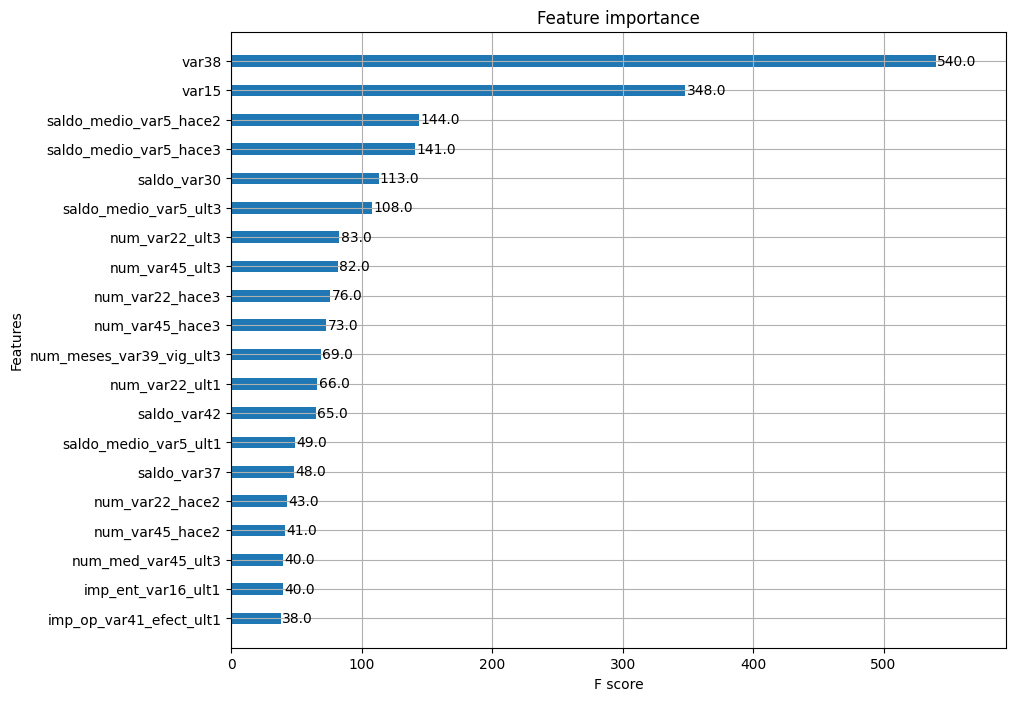

In [35]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (10, 8))
plot_importance(xgb_clf, ax = ax, max_num_features= 20, height=0.4)

# LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [36]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 500, early_stopping_rounds = 100, eval_metric = "auc")
eval_set = [(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, eval_set = eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

In [46]:
# 하이퍼 파라미터 튜닝

lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                     }

In [48]:
# 목적 함수 생성

def objective_func(search_space):
  lgbm_clf = LGBMClassifier(n_estimators = 100,
                           num_leaves = int(search_space['num_leaves']),
                           max_depth=int(search_space['max_depth']),
                           min_child_samples = int(search_space['min_child_samples']),
                           subsample = search_space['subsample'],
                           learning_rate = search_space['learning_rate'],
                           early_stopping_rounds = 30, eval_metric = "auc"
                           )

  # 3개 k-fold 방식으로 평가된 roc-auc 지표를 담는 list
  roc_auc_list = []

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits = 3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    lgbm_clf.fit(X_tr, y_tr, eval_set = [(X_tr, y_tr), (X_val, y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
    roc_auc_list.append(score)

  # 3 개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1 * np.mean(roc_auc_list)

In [49]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space = lgbm_search_space,
            algo = tpe.suggest,
            max_evals = 50, # 최대 반복 횟수를 지정합니다.
            trials = trials, rstate = np.random.default_rng(seed=30))

print('best:', best)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until va

In [55]:
lgbm_clf = LGBMClassifier(n_estimators = 500, num_leaves = int(best['num_leaves']),
                          max_depth = int(best['max_depth']),
                          min_child_samples = int(best['min_child_samples']),
                          learning_rate = round(best['learning_rate'], 5),
                          subsample = round(best['subsample'], 5),
                          early_stopping_rounds = 100,
                          eval_metric = "auc"
                          )

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
lgbm_clf.fit(X_tr, y_tr, eval_set = [(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12898
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

# 분류 실습 2 - 캐글 신용카드 사기 검출

0 - 사기가 아닌 정상적인 신용카드 트랜잭션 데이터
1 - 신용카드 사기 트랜잭션

전체 데이터의 0.172%만이 레이블 값을 1을 가지는 매우 불균형한 분포의 데이터

레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있는데, 이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 매우 적기 때문에 발생함.

**지도 학습에서 불균형한 레이블 분포로 인한 문제점 해결 방안**

1. 언더 샘플링
- 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소시킴

2. 오버 샘플링
- 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식
> 단순히 증식시키는 방법은 과적합이 되기 때문에 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식시킴

 > 대표적인 방법: SMOTE - 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식

In [56]:
# conda install -c conda-forge imbalanced-learn

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv("/content/creditcard[1].csv")
card_df.head(3)

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]

Time: 의미 없는 속성이므로 제거 가능

Amount: 신용카드 트랜잭션 금액 의미

Class: 0이면 정상, 1이면 사기 트랜잭션

In [99]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis = 1, inplace = True)
  return df_copy

In [100]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.

def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = \
  train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [101]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [102]:
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test,pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test,pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도:{0:4f},정밀도:{1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [103]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   57    91]]
정확도:0.999169,정밀도:0.8667, 재현율: 0.6149, F1:0.7194, AUC:0.974104


In [104]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행.

def get_model_train_eval(model, ftr_train =None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [105]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

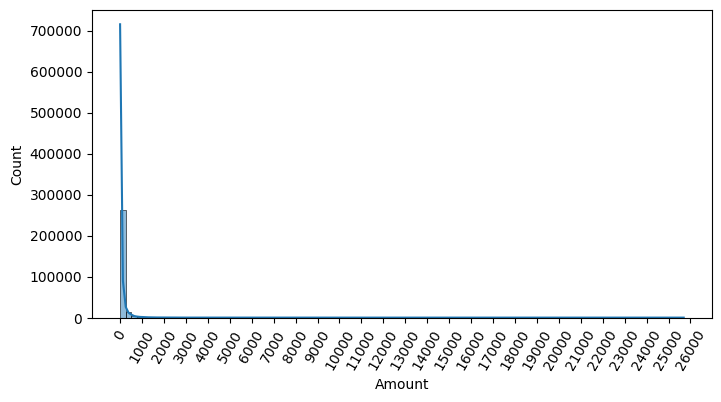

In [107]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [108]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
  #변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

In [109]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도:0.999192,정밀도:0.8692, 재현율: 0.6284, F1:0.7294, AUC:0.970603
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [111]:
#로그 변환

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  # 넘파이의 log1p( )를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [112]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도:0.999157,정밀도:0.8725, 재현율: 0.6014, F1:0.7120, AUC:0.973444
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

<Axes: >

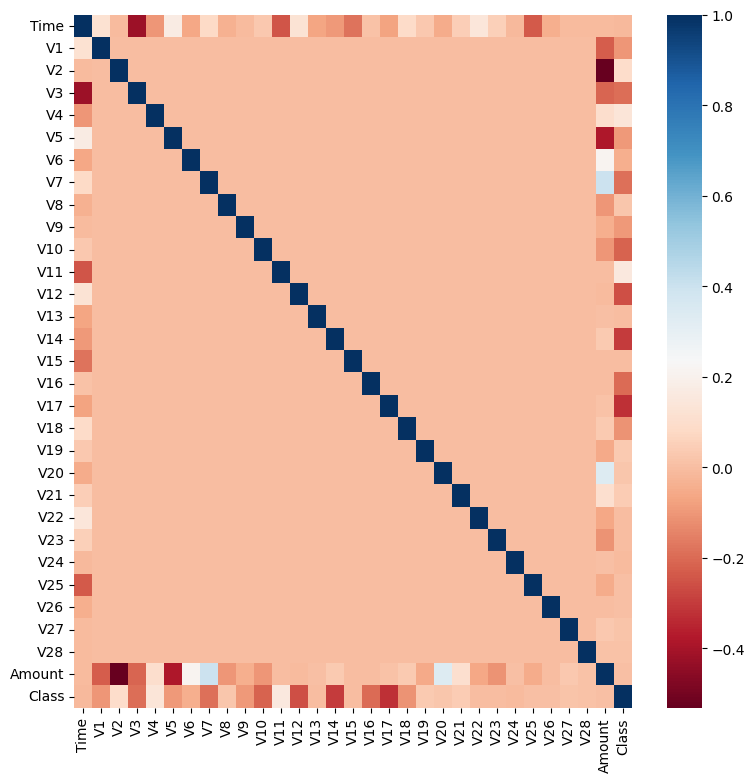

In [113]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [114]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud = df[df['Class' ]==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
 # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

In [115]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [116]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                     tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85280    15]
 [   48    98]]
정확도:0.999263,정밀도:0.8673, 재현율: 0.6712, F1:0.7568, AUC:0.972480
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [118]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [121]:
lr_clf = LogisticRegression(max_iter=1000)
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도:0.972226,정밀도:0.0541, 재현율: 0.9247, F1:0.1022, AUC:0.973641


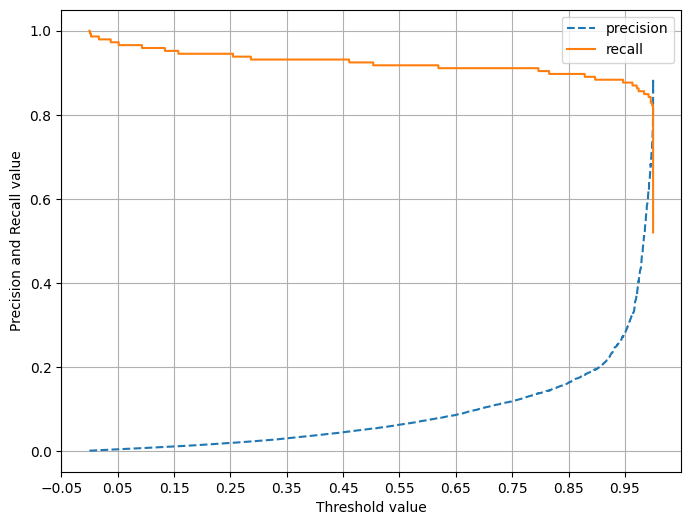

In [122]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
  plt.figure(figsize=(8, 6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [123]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split